In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd

ox.config(log_console=True, use_cache=True)
weight_by_length = False

ox.__version__

'0.11.4'

In [10]:
# define the study sites as label : query
places = {'Aguascalientes' :'Aguascalientes, Mexico',
         'Monterrey'       : 'Nuevo Leon, Mexico',
        'Guadalajara'       : 'Jalisco, Mexico',
          'Oaxaca'       : 'Oaxaca, Mexico'}

In [11]:
# verify OSMnx geocodes each query to what you expect (a [multi]polygon geometry)
gdf = ox.gdf_from_places(places.values())
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-102.87418 21.85277, -102.87389 21.8...","Aguascalientes, Mexico",22.459590,21.622266,-101.835289,-102.874177
1,"POLYGON ((-101.20676 26.36978, -101.18544 26.3...","Nuevo León, Mexico",27.799137,23.162665,-98.421576,-101.206763
2,"POLYGON ((-105.69540 20.40627, -105.69492 20.4...","Jalisco, Mexico",22.750246,18.925872,-101.510542,-105.695403
3,"MULTIPOLYGON (((-98.55270 16.31629, -98.55265 ...","Oaxaca, Mexico",18.669688,15.656878,-93.867427,-98.552696


In [12]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [13]:
bearings = {}
for place in sorted(places.keys()):
    print(datetime.datetime.now(), place)
    
    # get the graph
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

2020-03-12 18:26:47.695659 Aguascalientes
2020-03-12 18:28:44.697599 Guadalajara
2020-03-12 19:08:43.993358 Monterrey
2020-03-12 19:25:30.505144 Oaxaca


In [14]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [15]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Century Gothic', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Century Gothic', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [16]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':60, 'fontweight':'normal', 'y':1.07}
fig.suptitle('City Street Network Orientation', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig('street-orientations.png', dpi=120, bbox_inches='tight')
plt.close()

findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.


In [19]:
places

{'Aguascalientes': 'Aguascalientes, Mexico',
 'Monterrey': 'Nuevo Leon, Mexico',
 'Guadalajara': 'Jalisco, Mexico',
 'Oaxaca': 'Oaxaca, Mexico'}

In [20]:
G = ox.graph_from_place('Aguascalientes, Mexico', network_type = 'drive')

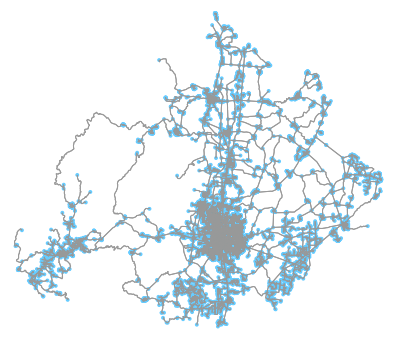

(<Figure size 545.24x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x225a3b1d0>)

In [21]:
ox.plot_graph(G)

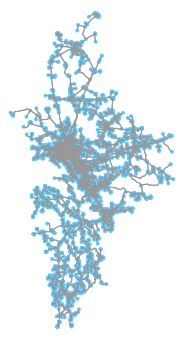

(<Figure size 248.529x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24461d3d0>)

In [22]:
G1 = ox.graph_from_place('Nuevo Leon, Mexico', network_type = 'drive')
ox.plot_graph(G1)

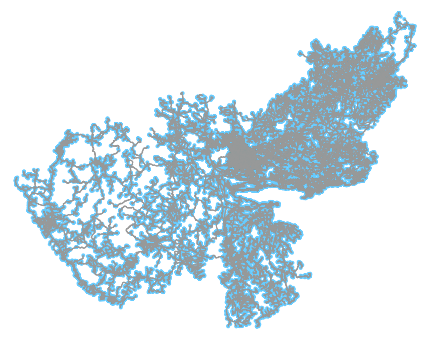

(<Figure size 587.778x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x335e21390>)

In [23]:
G2 = ox.graph_from_place('Jalisco, Mexico', network_type = 'drive')
ox.plot_graph(G2)

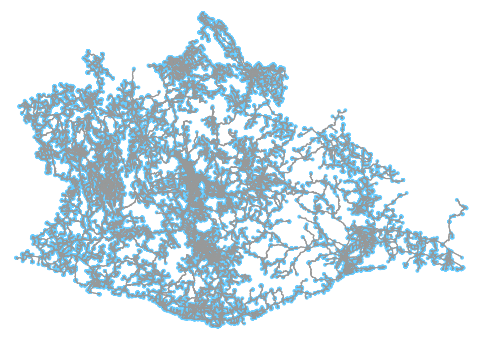

(<Figure size 649.189x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23c444710>)

In [24]:
G3 = ox.graph_from_place('Oaxaca, Mexico', network_type = 'drive')
ox.plot_graph(G3)

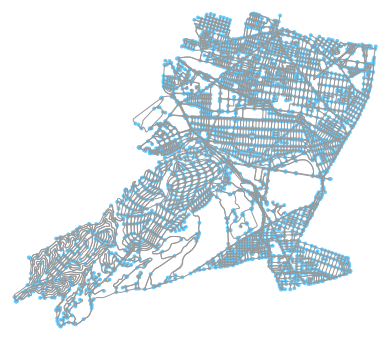

(<Figure size 527.759x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x139640d50>)

In [21]:
ox.plot_graph(g)